## Evaluate DPR Retriever Training

This currently includes a variety of ways to evaluate a retriever:
- Parsing the retriever training logs for validation loss
- Converting AmbigQA data to ground truth and inspecting the ground truth
- Evaluating retrievers on the ground truth (according to Recall@k)

Note some concerns that were raised by this:
- There are many duplicates of answers (both in the aliases where we could strip things like quotes, and in the alias lists b/c they might be used to answer different sub-questions).  Worth cleaning up if we care.

In [1]:
import json
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import multiqa_utils.eval_utils as eu
import multiqa_utils.ambigqa_utils as au

%load_ext autoreload
%autoreload 2

## Extract Useful Lines for Quick Glance at Perf

In [2]:
base_path = "/scratch/ddr8143/multiqa/baseline_runs_v0/"
run_name = "ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0"
log_file = f"{base_path}{run_name}/train_dense_encoder.log"

In [3]:
useful_lines = eu.parse_lines_from_dpr_retriever_training_logs(log_file)
useful_lines.keys()

dict_keys(['checkpoint_model', 'train_datasets', 'dev_datasets', 'aggregated_data_size', 'cleaned_data_size', 'shard_info', 'epoch_losses', 'nll_validation', 'best_checkpoint', 'avg_rank_validation'])

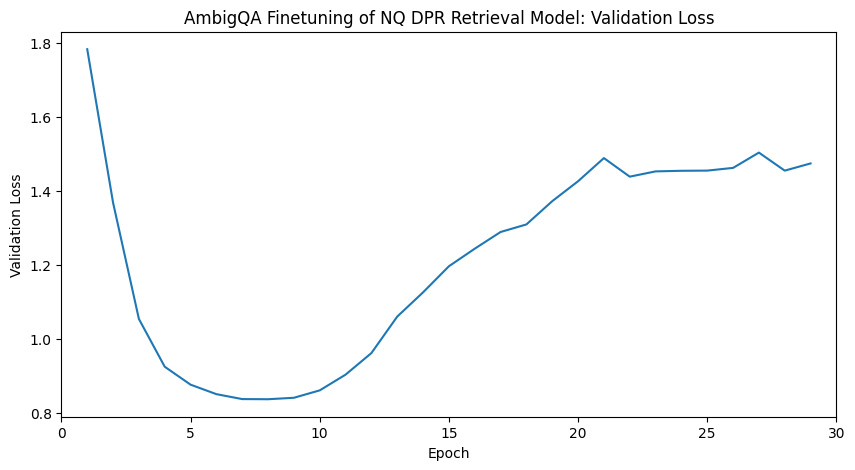

In [4]:
# Obviously this can be generalized to plot other things
eu.plot_nll_validation_from_dpr_retriever_useful_lines(useful_lines)

## Evaluate Retriever Via MRR

In [5]:
original_file = json.load(open("/scratch/ddr8143/multiqa/downloads/data/ambigqa_light/dev.json"))
bm25_retrieval = json.load(open("/scratch/ddr8143/multiqa/processed_datasets/bm25.ambigqa_light.dev.h100.json__contexts"))
bm25_retrieval_list = list(bm25_retrieval.values())
nq_retrieval = json.load(open("/scratch/ddr8143/multiqa/baseline_runs_v0/nq_downloaded_index_checkpoint.ambigqa_dev.json"))
ambigqa_retrieval = json.load(open("/scratch/ddr8143/multiqa/baseline_runs_v0/ambigqa_bm25_100.from_nq.bs_48.ws_4.t_0.s_0/checkpoint_8.ambigqa_dev.json"))


**Convert AmbigQA into GT**

In [6]:
ground_truth = au.convert_original_to_ground_truth(original_file)
list(ground_truth.items())[0]

('Who plays the doctor in dexter season 1?', [['Tony Goldwyn', 'Goldwyn']])

In [7]:
min_num_to_print = 20
print(f"All questions with more than {min_num_to_print} answers:\n")
num_gt_answers = []
for k, v in ground_truth.items():
    num_gt_answers.append(len(v))
    if len(v) > min_num_to_print:
        print(k, v)
print()
print(f"Min #Ans: {min(num_gt_answers)}, Max: {max(num_gt_answers)}, Avg: {sum(num_gt_answers)/len(num_gt_answers):0.2f}")

All questions with more than 20 answers:

Who was executed by firing squad in utah? [['William Cockcroft'], ['"Unknown Man"', 'Unknown Man'], ['Jason R. Luce'], ['Robert Sutton'], ['Chauncy W. Millard'], ['John Doyle Lee'], ['Wallace Wilkerson'], ['Frederick Hopt', 'Fred Welcome'], ['Enoch Davis'], ['Pat Coughlin'], ['Peter Mortensen'], ['Frank Rose'], ['Jules Zirmay', 'Jules C. E. Szirmay'], ['Harry Thorne'], ['Thomas Riley'], ['Frank Romeo'], ['Joe Hill'], ['Howard DeWeese'], ['John Borich'], ['Steve Maslich'], ['Nick Oblizalo'], ['George H. Gardner'], ['Omer R. Woods'], ['Henry C. Hett', 'George Allen'], ['Pedro Cano'], ['Ralph W. Seyboldt'], ['Edward McGowan'], ['Delbert Green'], ['John W. Deering'], ['Donald Lawton Condit'], ['Robert Walter Avery'], ['Austin Cox Jr.'], ['James Joseph Roedl'], ['Eliseo J. Mares Jr.'], ['Ray Dempsey Gardner'], ['Don Jesse Neal'], ['Verne Alfred Braasch', 'Melvin Leroy Sullivan'], ['James W. Rodgers'], ['Gary Gilmore'], ['John Albert Taylor'], ['Ronn

**Evaluate the Different Retrievers**

In [8]:
bm25_retrieval_list = list(bm25_retrieval.values())

In [9]:
result_formatstr = "|     {dataset:15} %Ans at 100, 10, 3     || {avg100:0.2f} | {avg10:0.2f} | {avg3:0.2f} |"

In [10]:
datasets = {
    "BM25": bm25_retrieval_list,
    "NQ DPR": nq_retrieval,
    "NQftAB DPR": ambigqa_retrieval,
}

In [11]:
results = {k: {} for k in datasets.keys()}

In [12]:
for d, rl in datasets.items():
    ioas, _ = eu.get_index_of_context_with_answers(rl, ground_truth)
    for k in [3, 10, 100]:
        results[d][k], _, _ = eu.ioa_to_rankPatK(ioas, k)

In [13]:
print("Percent Answers at 100, 10, 3")
for d, dks in results.items():
    print(result_formatstr.format(
        dataset=d,
        avg100=dks[100] * 100.0,
        avg10=dks[10] * 100.0,
        avg3=dks[3] * 100.0,
    ))

Percent Answers at 100, 10, 3
|     BM25            %Ans at 100, 10, 3     || 70.14 | 49.11 | 34.37 |
|     NQ DPR          %Ans at 100, 10, 3     || 81.77 | 68.27 | 53.41 |
|     NQftAB DPR      %Ans at 100, 10, 3     || 83.62 | 67.50 | 52.03 |


**Plot the data**

In [23]:
data = {d: [dres[k]*100.0 for k in [3, 10, 100]] for d, dres in results.items()}
data

{'BM25': [34.365497930966484, 49.11128785532784, 70.14059438469272],
 'NQ DPR': [53.40976773500731, 68.26838428460815, 81.76688780957066],
 'NQftAB DPR': [52.02742174105417, 67.50260747930608, 83.61801149269628]}

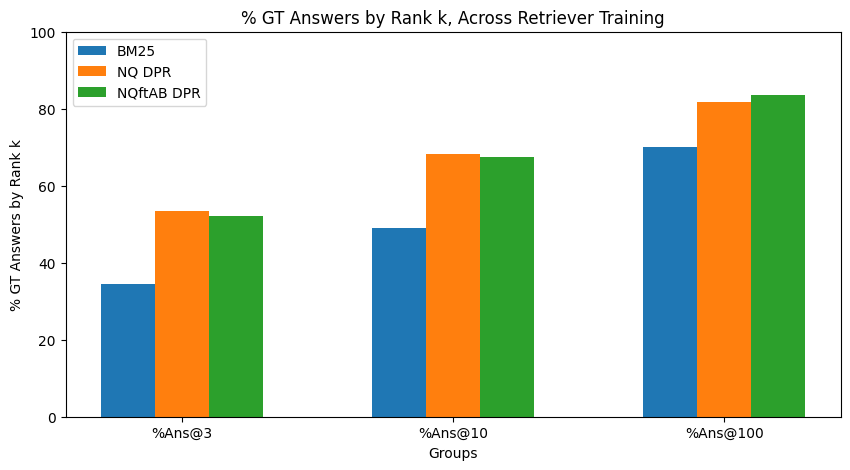

In [25]:
X_axis = np.arange(3)

fig = plt.figure(figsize=(10,5))
i = -1
for k, v in data.items():
    plt.bar(X_axis + (i * 0.2) , v, 0.2, label = k)
    i += 1
  
plt.xticks(X_axis, ["%Ans@3", "%Ans@10", "%Ans@100"])
plt.xlabel("Groups")
plt.ylim([0, 100])
plt.ylabel("% GT Answers by Rank k")
plt.title("% GT Answers by Rank k, Across Retriever Training")
plt.legend()
plt.show()